In [1]:
import os
import sys
import time
import socket
import random
import argparse
import importlib
import scipy.misc
import statistics 
import numpy as np
import tensorflow as tf
from scipy import stats
import matplotlib.pyplot as plt
from timeit import default_timer as timer
%matplotlib inline

# Append python path
BASE_DIR = os.path.dirname(os.path.abspath('__file__'))
sys.path.append(BASE_DIR)
sys.path.append(os.path.join(BASE_DIR, 'utils'))
sys.path.append(os.path.join(BASE_DIR, 'models'))

# Import pointnet stuff
import pc_util
import provider

# BASIC CONFIGURATION

In [2]:
DATASET = 'modelnet'  # modelnet or shapenet

# ModelNet40 official train/test split
if DATASET == 'modelnet':
    NUM_CLASSES = 40
    LOGS_DIR = 'logs_modelnet'
    SHAPE_NAMES = [line.rstrip() for line in open(os.path.join(BASE_DIR, 'data/modelnet40_ply_hdf5_2048/shape_names.txt'))] 
    TRAIN_FILES = provider.getDataFiles(os.path.join(BASE_DIR, 'data/modelnet40_ply_hdf5_2048/train_files.txt'))
    TEST_FILES = provider.getDataFiles(os.path.join(BASE_DIR, 'data/modelnet40_ply_hdf5_2048/test_files.txt'))
elif DATASET == 'shapenet'
    NUM_CLASSES = 55
    LOGS_DIR = 'logs_shapenet'
    SHAPE_NAMES = [line.rstrip() for line in open(os.path.join(BASE_DIR, 'data/shapenet_core55_1024/shape_names.txt'))] 
    TRAIN_FILES = provider.getDataFiles(os.path.join(BASE_DIR, 'data/shapenet_core55_1024/train_files.txt'))
    TEST_FILES = provider.getDataFiles(os.path.join(BASE_DIR, 'data/shapenet_core55_1024/test_files.txt'))
    
BATCH_SIZE = 192
NUM_POINT = 1024
GPU_INDEX = 0
MODEL = importlib.import_module('pointnet_cls') # import network module
DUMP_DIR = 'dump'
VISUALIZATION = False
if not os.path.exists(DUMP_DIR):
    os.mkdir(DUMP_DIR)
HOSTNAME = socket.gethostname()


# EVALUATE ONE EPOCH METHOD

Args:

  **sess** - tf session
  
  **ops** - parameters
  
  

Returns:

  **loss** - mean classification loss
  
  **accuracy** - instance classification accuracy
  
  **class_accuracy** - class classification accuracy
  
  **predictions** - array of the output ofthe classification module with shape: (N, 40), where N is the test clouds len
  
  **true_labels** - true labels of test clouds with the lenght of N
  

In [3]:
def eval_one_epoch(sess, ops, num_votes=1, topk=1, verbose=False):
    error_cnt = 0
    is_training = False
    total_correct = 0
    total_seen = 0
    loss_sum = 0
    total_seen_class = [0 for _ in range(NUM_CLASSES)]
    total_correct_class = [0 for _ in range(NUM_CLASSES)]
    fout = open(os.path.join(DUMP_DIR, 'pred_label.txt'), 'w')
    data_vals = []
    pred_vals = []
    true_vals = []
    for fn in range(len(TEST_FILES)):
        if verbose:
            print('----'+str(fn)+'----')
        current_data, current_label = provider.loadDataFile(TEST_FILES[fn])
        current_data = current_data[:,0:NUM_POINT,:]
        data_vals.append(np.copy(current_data))
        current_label = np.squeeze(current_label)
        
        ###############################################################
        # PAD DATA IF NEEDED
        ###############################################################
        
        if len(current_label) % BATCH_SIZE != 0:
            multpl = np.ceil(len(current_label)/ BATCH_SIZE)
            how_many = int(multpl*BATCH_SIZE - len(current_label))
            padded_label = np.pad(current_label, (0, how_many), 'edge')
            padded_data = np.pad(current_data, ((0, how_many), (0,0), (0,0)), 'edge')
        else:
            padded_label = current_label
            padded_data = current_data
        num_batches = int(len(padded_label) / BATCH_SIZE)
        
        ###############################################################
        # LOOP FOR EVERY BATCH (LAST BATCH COULD BE PADDED)
        ###############################################################
        for batch_idx in range(num_batches):
            
            # Indices
            start_idx = batch_idx * BATCH_SIZE
            end_idx = (batch_idx+1) * BATCH_SIZE
            if len(padded_data) - len(current_data) and batch_idx == num_batches - 1:
                cur_batch_size = len(current_data) % BATCH_SIZE
            else:
                cur_batch_size = BATCH_SIZE
            
            # Aggregating BEG
            batch_loss_sum = 0 # sum of losses for the batch
            batch_pred_sum = np.zeros((cur_batch_size, NUM_CLASSES)) # score for classes
            batch_pred_classes = np.zeros((cur_batch_size, NUM_CLASSES)) # 0/1 for classes
            
            # Votes
            for vote_idx in range(num_votes):
                rotated_data = provider.rotate_point_cloud_by_angle(padded_data[start_idx:end_idx, :, :],
                                                  vote_idx/float(num_votes) * np.pi * 2)
                feed_dict = {ops['pointclouds_pl']: rotated_data,
                             ops['labels_pl']: padded_label[start_idx:end_idx],
                             ops['is_training_pl']: is_training}
                loss_val, pred_val = sess.run([ops['loss'], ops['pred']],
                                          feed_dict=feed_dict)
                batch_pred_sum += pred_val[:cur_batch_size]
                batch_pred_val = np.argmax(pred_val, 1)
                for el_idx in range(cur_batch_size):
                    batch_pred_classes[el_idx, batch_pred_val[el_idx]] += 1
                batch_loss_sum += (loss_val * cur_batch_size / float(num_votes))

            # DANIEL
            pred_vals.append(batch_pred_sum.copy())
            true_vals.append(padded_label[start_idx:start_idx+cur_batch_size].copy())
        
            # pred_valloss_sum_topk = np.argsort(batch_pred_sum, axis=-1)[:,-1*np.array(range(topk))-1]
            # pred_val = np.argmax(batch_pred_classes, 1)
            pred_val = np.argmax(batch_pred_sum, 1)
            # Aggregating END
            
            correct = np.sum(pred_val == padded_label[start_idx:start_idx+cur_batch_size])
            # correct = np.sum(pred_val_topk[:,0:topk] == label_val)
            total_correct += correct
            total_seen += cur_batch_size
            loss_sum += batch_loss_sum

            for i in range(start_idx, start_idx + cur_batch_size):
                l = current_label[i]
                total_seen_class[l] += 1
                total_correct_class[l] += (pred_val[i-start_idx] == l)
                fout.write('%d, %d\n' % (pred_val[i-start_idx], l))
                
                if pred_val[i-start_idx] != l and VISUALIZATION: # ERROR CASE, DUMP!
                    img_filename = '%d_label_%s_pred_%s.jpg' % (error_cnt, SHAPE_NAMES[l],
                                                           SHAPE_NAMES[pred_val[i-start_idx]])
                    img_filename = os.path.join(DUMP_DIR, img_filename)
                    output_img = pc_util.point_cloud_three_views(np.squeeze(current_data[i, :, :]))
                    scipy.misc.imsave(img_filename, output_img)
                    error_cnt += 1
    
    eval_mean_loss = (loss_sum / float(total_seen))
    eval_instance_acc = (total_correct / float(total_seen))
    eval_class_acc = (np.mean(np.array(total_correct_class)/np.array(total_seen_class,dtype=np.float)))
    
    pred_vals = np.concatenate(pred_vals)
    true_vals = np.concatenate(true_vals)
    data_vals = np.concatenate(data_vals)
    
    if verbose:
        print('eval mean loss: %f' % eval_mean_loss)
        print('eval accuracy: %f' % eval_instance_acc)
        print('eval avg class acc: %f' % eval_class_acc)
    
    class_accuracies = np.array(total_correct_class)/np.array(total_seen_class,dtype=np.float)
    if verbose:
        for i, name in enumerate(SHAPE_NAMES):
            print('%10s:\t%0.3f' % (name, class_accuracies[i]))
            
    return eval_mean_loss, eval_instance_acc, eval_class_acc, pred_vals, true_vals, data_vals

# EVALUATE METHOD

Args:

  **model_num** - number of the pointnet model (i.e.: 3 to evaluate model_3.ckpt model)
  
  **num_votes** - how many votes (one vote is one pc rotation & permutation) should be used to eval the model

Returns:

  ** same as *eval_one_epoch* **

In [4]:
def evaluate(model_num, num_votes=1, verbose=False):
    is_training = False
    
    # Reset
    tf.reset_default_graph()
     
    with tf.device('/GPU:'+str(GPU_INDEX)):
        pointclouds_pl, labels_pl = MODEL.placeholder_inputs(BATCH_SIZE, NUM_POINT)
        is_training_pl = tf.placeholder(tf.bool, shape=())

        # simple model
        pred, end_points = MODEL.get_model(pointclouds_pl, is_training_pl, num_classes=NUM_CLASSES)
        loss = MODEL.get_loss(pred, labels_pl, end_points)

        # Add ops to save and restore all the variables.
        saver = tf.train.Saver()
        
    # Create a session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.allow_soft_placement = True
    config.log_device_placement = True
    sess = tf.Session(config=config)

    # Get model path
    model_path = os.path.join(LOGS_DIR + '/logs_' str(model_num), 'model.ckpt')
    
    # Restore variables from disk.
    saver.restore(sess, model_path)
    if verbose:
        print("Model restored.")

    ops = {'pointclouds_pl': pointclouds_pl,
           'labels_pl': labels_pl,
           'is_training_pl': is_training_pl,
           'pred': pred,
           'loss': loss}

    return eval_one_epoch(sess, ops, num_votes, verbose)

In [10]:
start = timer()
_, acc, _, _, labels, data = evaluate(model_num=1, num_votes=1, verbose=False)
end = timer()
print ('acc =', acc, 'calc time [min] =', (end-start)/60)

INFO:tensorflow:Restoring parameters from logs_shapenet/log_1/model.ckpt
acc = 0.8827835345565168 calc time [min] = 2.0421368139999987


In [7]:
np.save(LOGS_DIR + '/xdata.npy', data)

# # # # # # # # # # # # # # # # # # # # # # # # # # #
# NUM_VOTES TEST
# # # # # # # # # # # # # # # # # # # # # # # # # # #

In [11]:
NUM_VOTES = 15
RANGE_MODELS = range(1, 3)
num_votes_accs = {i: [] for i in RANGE_MODELS}
for i in num_votes_accs:
    for x in range(1, NUM_VOTES+1):
        start = timer()
        _, acc, _, _, _, _ = evaluate(model_num=i, num_votes=x, verbose=False)
        end = timer()
        num_votes_accs[i].append(acc)
        print ('i =', i, 'x =', x, 'acc = ', acc, 'calc time [min] =', (end-start)/60)

INFO:tensorflow:Restoring parameters from logs_shapenet/log_1/model.ckpt
i = 1 x = 1 acc =  0.8827835345565168 calc time [min] = 2.032128428500012
INFO:tensorflow:Restoring parameters from logs_shapenet/log_1/model.ckpt
i = 1 x = 2 acc =  0.885160186329499 calc time [min] = 4.03951708655001
INFO:tensorflow:Restoring parameters from logs_shapenet/log_1/model.ckpt
i = 1 x = 3 acc =  0.885160186329499 calc time [min] = 6.032390051799999
INFO:tensorflow:Restoring parameters from logs_shapenet/log_1/model.ckpt
i = 1 x = 4 acc =  0.8849700541876604 calc time [min] = 8.041456444816655
INFO:tensorflow:Restoring parameters from logs_shapenet/log_1/model.ckpt
i = 1 x = 5 acc =  0.8855404506131762 calc time [min] = 10.053172142849993
INFO:tensorflow:Restoring parameters from logs_shapenet/log_1/model.ckpt
i = 1 x = 6 acc =  0.8859207148968533 calc time [min] = 12.057802031166679
INFO:tensorflow:Restoring parameters from logs_shapenet/log_1/model.ckpt
i = 1 x = 7 acc =  0.8856355166840955 calc tim

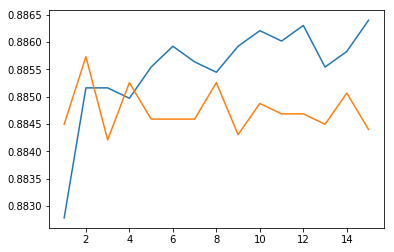

In [12]:
for i in num_votes_accs:
    plt.plot(np.arange(1, 1+len(num_votes_accs[i])), num_votes_accs[i])
plt.savefig(LOGS_DIR + '/num_votes.png')

# # # # # # # # # # # # # # # # # # # # # # # # #
# MODEL ENSEMBLING 
# # # # # # # # # # # # # # # # # # # # # # # # #

## Calculate probabilities for each test cloud and each model. The output probability array will be the shape of (N, NUM_CLASSES, X), where N is the test cloud len and X is the models count to be ensembled.


In [6]:
NUM_MODELS = 10
NUM_VOTES = 12
probabilities = []
true_labels = []
accuracies = []
for x in range(NUM_MODELS):
    start = timer()
    loss, instance_acc, class_acc, pred_vals, true_vals, data = evaluate(model_num=x, num_votes=NUM_VOTES, verbose=False)
    end = timer()
    probabilities.append(pred_vals)
    accuracies.append(instance_acc)
    true_labels = np.array(true_vals)
    print ('Model =', x, 'acc =', instance_acc, 'time [min] =', (end-start)/60)
    
probabilities = np.stack(probabilities).transpose(1, 2, 0)
accuracies = np.array(accuracies)

INFO:tensorflow:Restoring parameters from logs_shapenet/log_0/model.ckpt
Model = 0 acc = 0.8747029185283772 time [min] = 24.04758900225
INFO:tensorflow:Restoring parameters from logs_shapenet/log_1/model.ckpt
Model = 1 acc = 0.8863009791805305 time [min] = 24.09609003128334
INFO:tensorflow:Restoring parameters from logs_shapenet/log_2/model.ckpt
Model = 2 acc = 0.8846848559749025 time [min] = 24.160206007233334
INFO:tensorflow:Restoring parameters from logs_shapenet/log_3/model.ckpt
Model = 3 acc = 0.885160186329499 time [min] = 24.218833024833323
INFO:tensorflow:Restoring parameters from logs_shapenet/log_4/model.ckpt
Model = 4 acc = 0.8865861773932884 time [min] = 24.270162222766672
INFO:tensorflow:Restoring parameters from logs_shapenet/log_5/model.ckpt
Model = 5 acc = 0.8861108470386919 time [min] = 24.140531683416672
INFO:tensorflow:Restoring parameters from logs_shapenet/log_6/model.ckpt
Model = 6 acc = 0.8849700541876604 time [min] = 24.08788911628335
INFO:tensorflow:Restoring p

In [7]:
np.save(LOGS_DIR + '/probabilities.npy', probabilities)
np.save(LOGS_DIR + '/true_labels.npy', true_labels)
np.save(LOGS_DIR + '/accuracies.npy', accuracies)

# Models evaluation statistics

In [9]:
print('Mean accuracy =', statistics.mean(accuracies))
indices = {}
for k in range(40):
    indices[k] = [i for i, x in enumerate(true_labels) if x == k]
    
validation_max_res = []
test_res_at_validation_max = []

for _ in range(1000):
    validation_indices = []
    test_indices = []
    for k in indices:
        random.shuffle(indices[k])
        split_idx = int(len(indices[k])/2)
        validation_indices += indices[k][:split_idx]
        test_indices += indices[k][split_idx:]
    validation_indices = sorted(validation_indices)
    test_indices = sorted(test_indices)

    validation_true_labels = true_labels[validation_indices]
    validation_probabilities = probabilities[validation_indices]
    test_true_labels = true_labels[test_indices]
    test_probabilities = probabilities[test_indices]

    validation_predictions = np.argmax(validation_probabilities, axis=1)
    validation_compare = np.equal(validation_predictions, np.expand_dims(validation_true_labels, -1))
    validation_accuracies = np.mean(validation_compare, axis=0)

    test_predictions = np.argmax(test_probabilities, axis=1)
    test_compare = np.equal(test_predictions, np.expand_dims(test_true_labels, -1))
    test_accuracies = np.mean(test_compare, axis=0)

    validation_max_res.append(np.max(validation_accuracies))
    test_res_at_validation_max.append(test_accuracies[np.argmax(validation_accuracies)])
    
mean_valid_max = statistics.mean(validation_max_res)
mean_test_at_valid_max = statistics.mean(test_res_at_validation_max)

print('Mean of validation max results =', mean_valid_max)
print('Mean of test result for validation max =', mean_test_at_valid_max)

Mean accuracy = 0.8842570586557658
Mean of validation max results = 0.8747351432880844
Mean of test result for validation max = 0.8692531455961654


# Agregate the outputs with sum operation

In [10]:
aggregated_probability = np.sum(probabilities, axis=-1)
aggregated_predictions = np.argmax(aggregated_probability, axis=-1)
float(np.sum(aggregated_predictions == true_labels)) / len(true_labels)

0.8911493487974143

# Agregate the outputs with mean operation

In [11]:
aggregated_probability = np.mean(probabilities, axis=-1)
aggregated_predictions = np.argmax(aggregated_probability, axis=-1)
float(np.sum(aggregated_predictions == true_labels)) / len(true_labels)

0.8911493487974143

# Agregate the outputs with mode operation

In [12]:
aggregated_predictions = np.argmax(probabilities, axis=1)
aggregated_predictions =  np.squeeze(stats.mode(aggregated_predictions, axis=1)[0])
float(np.sum(aggregated_predictions == true_labels)) / len(true_labels)

0.8893430934499477